# Classification Pipeline

This notebook contains examples of how to use the full classification pipeline to train, evaluate, and perform inference.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [3]:
import os
import yaml
import argparse

# Save program's directory
cwd = os.getcwd()
if cwd == '/content':  # If we are in colab, we mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change dir to where project is located
    os.chdir("drive/MyDrive/CoVision/classification")
    cwd = os.getcwd()
elif 'drive' in cwd:  # Already monted and changed dir
    pass
elif 'notebooks' in os.listdir(cwd):  # Local machine case
    cwd = './'
else:  # If currently in notebook folder
    os.chdir('./..')
    cwd = './'
print(f'Current working directory: {cwd}\n')

# Read arguments from dict and store them as Namespace
with open(cwd + 'config.yaml', 'r') as f:
    config_dict = yaml.safe_load(f)

# Update directories for colab
config_dict['data_args']['data_dir'] = os.path.join(cwd, config_dict['data_args']['data_dir'])
config_dict['training_args']['save_path'] = os.path.join(cwd, config_dict['training_args']['save_path'])
config_dict['inference_args']['output_dir'] = os.path.join(cwd, config_dict['inference_args']['output_dir'])

args = argparse.Namespace(**config_dict)
data_args = argparse.Namespace(**config_dict['data_args'])
training_args = argparse.Namespace(**config_dict['training_args'])
inference_args = argparse.Namespace(**config_dict['inference_args'])

print(data_args, '\n')
print(training_args, '\n')
print(inference_args, '\n')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: ./

Namespace(crop_locs=[0.1, 0.5, 0.9], data_dir='./data/', membrane_shape=[160, 480], sequences=['11', '10', '01', '00'], train_test_split=0.8, train_val_split=0.8, zone_shape=[160, 160]) 

Namespace(batch_size=16, epochs=10, lr=0.001, num_workers=0, save_path='./models/', scheduler_gamma=0.2, scheduler_step=30, seed=42, weight_decay=1e-05) 

Namespace(diagnosis_map={'11': 1, '10': 0, '01': 99, '00': 99}, output_dir='./results') 



## Data pre-processing

This section contains the steps to follow for preparing the raw membrane images and labels as required for training and testing the classification model. 

Given a new kit, e.g. deepblueag, the first step is to check whether the universal cropping-zone locations work out correctly with the new dataset. Such a visual inspection can be done via the `check_cropped_zones` function.

If the cropping inspection is succesfull, we split the data into train, validation, and test sets. In order to do so we use the custom function `split_data`.

In [2]:
import pandas as pd

from src.data.preprocessing import check_cropped_zones, split_data
from src.utils.visualization import show_dataset

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


In [9]:
kit_id='paramountag'
# check_cropped_zones(data_args, kit_id)

In [10]:
split_data(data_args, kit_id)

File ./data/paramountag/paramountag_labels.csv already has a train/val/test split! Do you want to overwrite it? (y/n): y
File ./data/paramountag/paramountag_labels.csv created succesfully!


train {'11': 70, '10': 57, '01': 0, '00': 2}
test {'11': 22, '10': 18, '01': 0, '00': 1}
val {'11': 18, '10': 15, '01': 0, '00': 1}


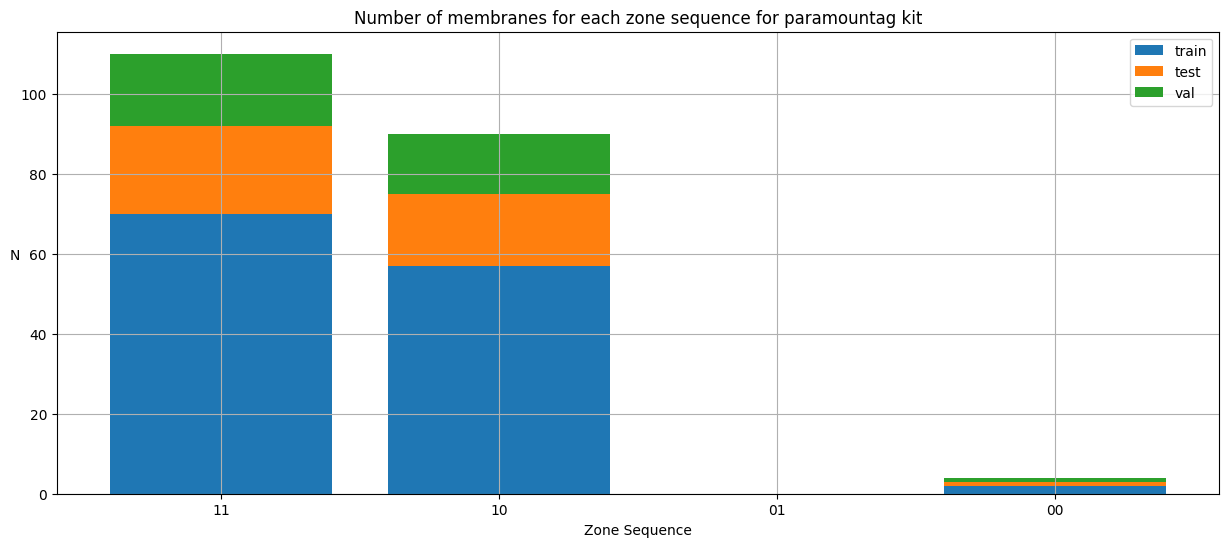

In [11]:
show_dataset(data_args, kit_id=kit_id)

In [12]:
labels_df = pd.read_csv(os.path.join(data_args.data_dir, kit_id, f'{kit_id}_labels.csv'), index_col=0, dtype=str)
print(labels_df.value_counts('data_mode'))
labels_df.head(10)

data_mode
train    129
test      41
val       34
dtype: int64


,line_sequence,data_mode
62864402522__8CDDC4FB-4C59-463B-BE9C-BC96B947704B,11,train
IMG_0686,11,train
IMG_0687,11,train
IMG_0688,11,val
IMG_0689,10,val
IMG_0690,11,train
IMG_0691,11,train
IMG_0692,11,train
IMG_0695,11,test
IMG_0696,11,train


## Model train

We use this section to train the model

In [13]:
from src.models.model_train import TrainerClassification
from src.utils.visualization import plot_metrics

In [22]:
kit_id='aconag'

training_args.lr = 0.0001
training_args.weight_decay = 0.0001
training_args.batch_size = 16
training_args.num_workers = 0
training_args.epochs = 10
training_args.scheduler_step = 11
training_args.scheduler_gamma = 0.5

# To train from scratch
trainer = TrainerClassification(args, kit_id=kit_id, do_validation=True, val_set='val', shots=None)

# To resume from saved state
# state_path = os.path.join(cwd + 'saved_models/2024-03-03_18.28.26_best.state')
# trainer = TrainerClassification.from_saved_state(state_path, new_epochs=1)

Using cpu device
Random seed set as 42
Loading data...
There are 205 membranes (410 zones) in the aconag kit for train data mode
There are 53 membranes (106 zones) in the aconag kit for val data mode


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

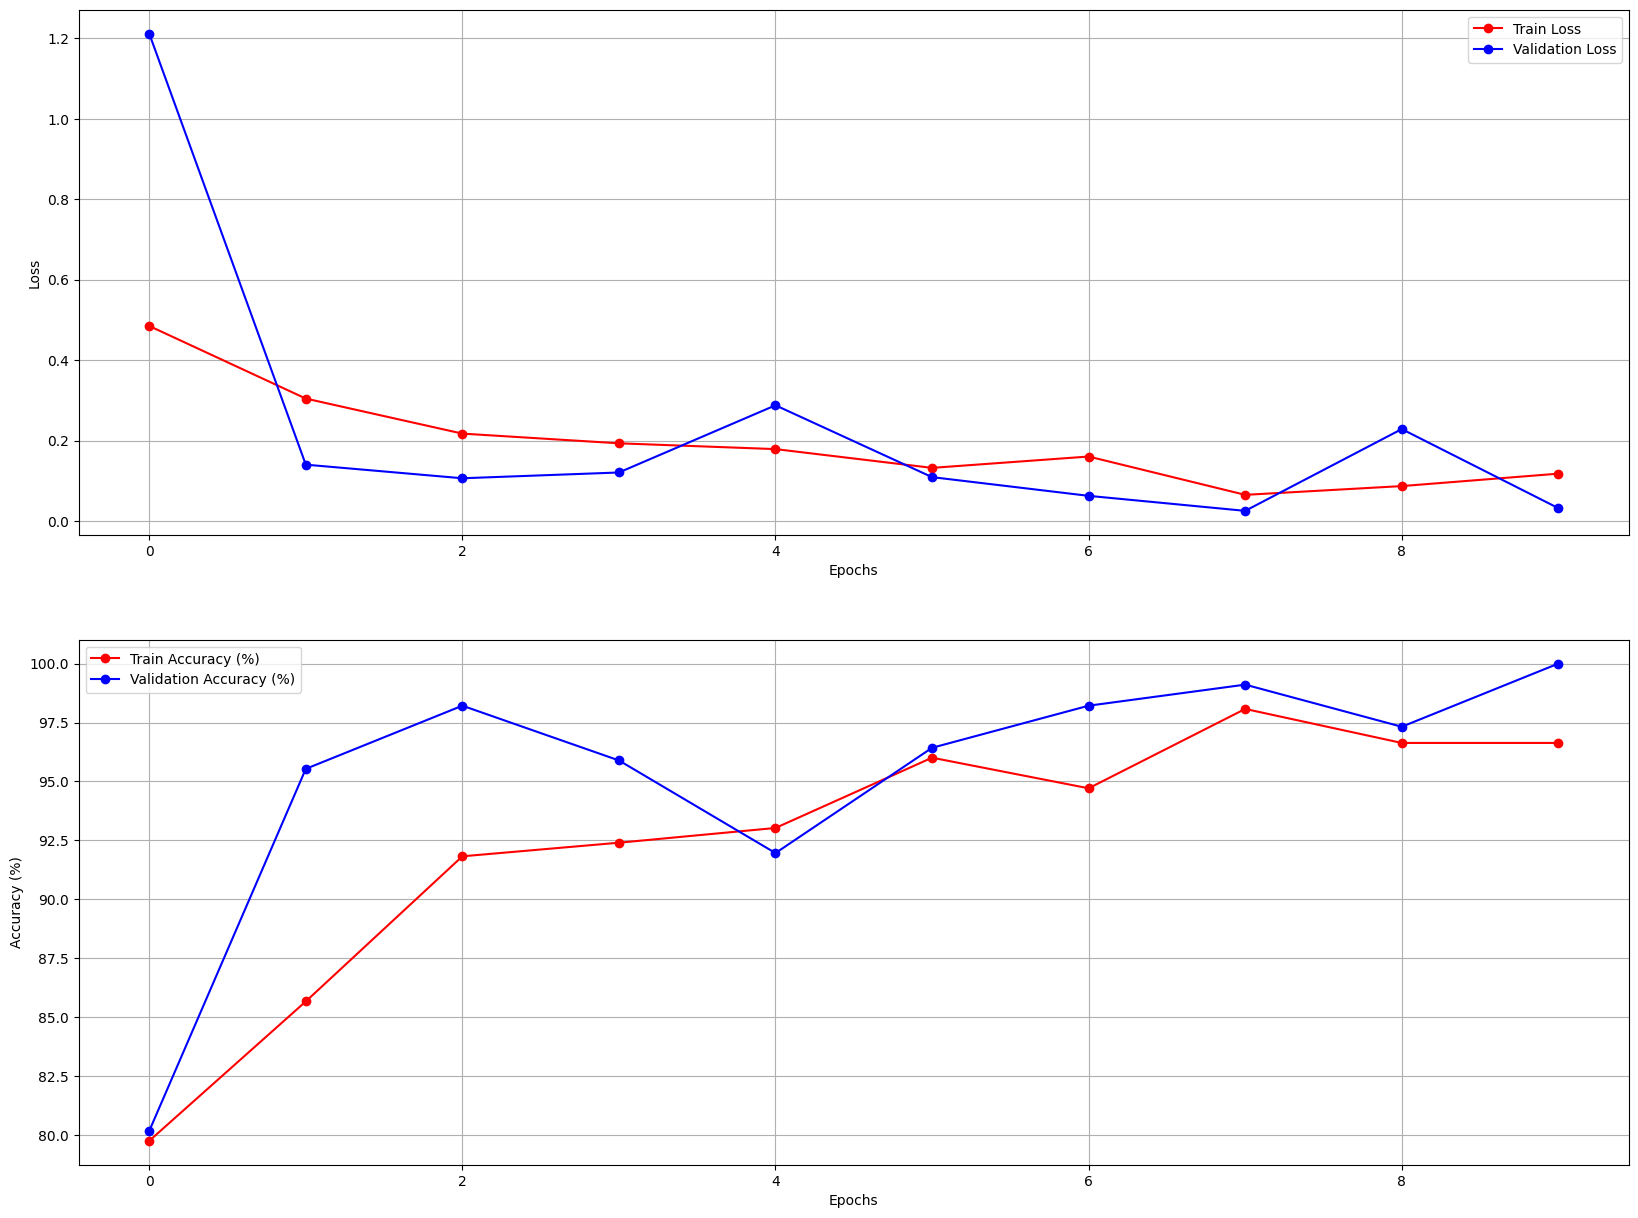

In [23]:
trainer.train(save_bool=False)
# trainer.save_txt_file()
plot_metrics(*trainer.get_metrics(), figsize=(20, 15))

## Model evaluation

In this section we evaluate models on different datasets, like train, val and test sets.

In [24]:
import torch

from src.models.model_evaluate import EvalClassification
from src.models.model_architecture import ClassificationModel
from src.utils.visualization import show_zones

In [26]:
# Load trained model's state
state_path = os.path.join(training_args.save_path, '2024-03-03_18.28.26_best.state')
model = ClassificationModel.from_pretrained(state_path)

In [27]:
tester = EvalClassification(args, model=model, device=None)

There are 181 membranes (362 zones) in the deepblueag kit for train data mode


  0%|          | 0/12 [00:00<?, ?it/s]

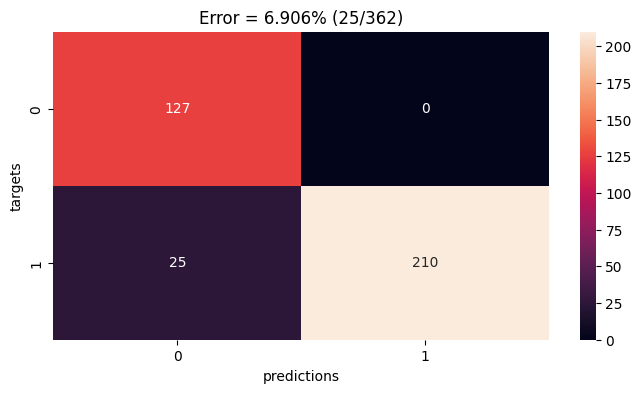

,zone_ndx,targets,predictions
filenames,,,
IMG_0034,1,1,0
IMG_0035,1,1,0
IMG_0037,1,1,0
IMG_0039,1,1,0
IMG_0040,1,1,0
IMG_0045,1,1,0
IMG_0080,1,1,0
IMG_0083,1,1,0
IMG_0085,1,1,0


In [29]:
kit_id = 'deepblueag'
data_mode = 'train'
misclassified_zones, misclassified_df = tester.evaluate(kit_id=kit_id, data_mode=data_mode, save_bool=False, save_filename=None)
misclassified_df

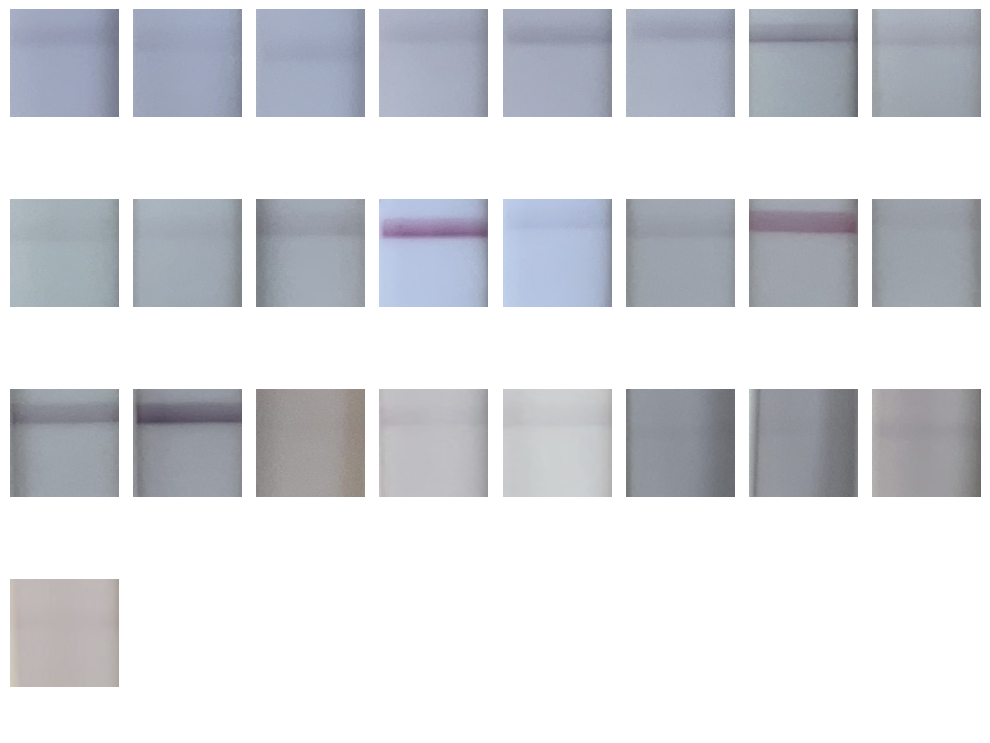

In [30]:
show_zones(misclassified_zones, n_cols=8,  mean=tester.transform.mean, std=tester.transform.std)

## Classify membrane

This final part of the pipeline takes a raw membrane image as input and returns whether it corresponds to a positive, negative, or invalid LFA test.

In [48]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from src.models.classify_membrane import classify_membrane
from src.models.model_architecture import ClassificationModel

In [49]:
# Load trained model's state
state_path = os.path.join(training_args.save_path, '2024-03-03_18.28.26_best.state')
model = ClassificationModel.from_pretrained(state_path)

In [50]:
# Get images from local folder
kit_id = 'aconag'
data_mode = 'test'

# Load full image paths of corresponding data_mode
filenames_df = pd.read_csv(os.path.join(data_args.data_dir, kit_id, f'{kit_id}_labels.csv'), index_col=0)
filenames = filenames_df[filenames_df.data_mode == data_mode].index.to_list()
image_paths = [os.path.join(data_args.data_dir, kit_id, f'{kit_id}_membranes', f'{n}.jpg') for n in filenames]

Positive (11)


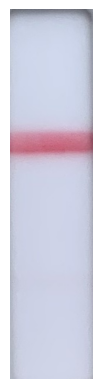

Negative (10)


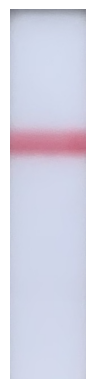

Negative (10)


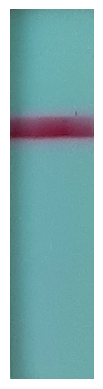

Negative (10)


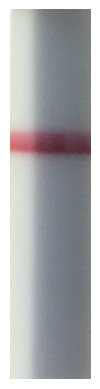

Negative (10)


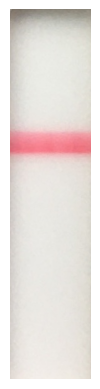

Negative (10)


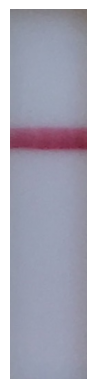

Invalid (00)


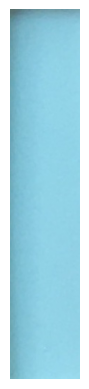

Negative (10)


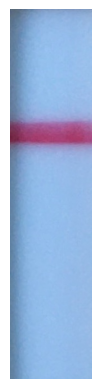

Negative (10)


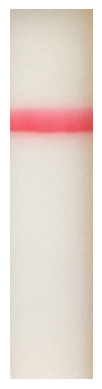

Positive (11)


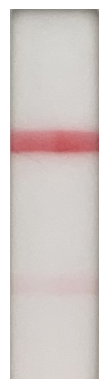

In [65]:
for i in range(10):
    path = image_paths[i]
    classify_membrane(args, path, model, show_bool=True)

In [4]:
import torch

from src.models.model_architecture import ClassificationModel

In [12]:
# Load trained model's state
state_path = os.path.join(training_args.save_path, '2024-03-03_18.28.26_best.state')
state = torch.load(state_path, map_location='cpu')
model = ClassificationModel()
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [14]:
torch.save(model, 'models/model_cla_v0.pt')

In [16]:
torch.load('models/model_cla_v0.pt')

ClassificationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,